In [69]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

In [70]:
# importing the data
data = np.loadtxt("http://www.gatsby.ucl.ac.uk/teaching/courses/ml1/co2.txt")
trend = data[:, 4]
labels = data[:, 3]
time = data[:, 2]

data


array([[1.980000e+03, 1.000000e+00, 1.980042e+03, 3.385500e+02,
        3.379300e+02],
       [1.980000e+03, 2.000000e+00, 1.980125e+03, 3.392700e+02,
        3.382200e+02],
       [1.980000e+03, 3.000000e+00, 1.980208e+03, 3.396000e+02,
        3.382500e+02],
       ...,
       [2.021000e+03, 6.000000e+00, 2.021458e+03, 4.153500e+02,
        4.147900e+02],
       [2.021000e+03, 7.000000e+00, 2.021542e+03, 4.136600e+02,
        4.149400e+02],
       [2.021000e+03, 8.000000e+00, 2.021625e+03, 4.123500e+02,
        4.150900e+02]])

In [71]:
# we concatenate the data with a  vector of ones to multiply it with the posterior weight vector.
features = np.concatenate((time[:, None], np.ones((time.shape))[:, None]), axis=1)
prior_cov = np.array([[100, 0], [0, 10000]])
prior_mean = np.array([0, 360])

# we use the formulae
post_cov = np.linalg.inv(features.T @ features + np.linalg.pinv(prior_cov))
post_mean = post_cov @ (features.T @ labels + np.linalg.pinv(prior_cov)@prior_mean)

[[ 1.37479698e-05 -2.75073908e-02]
 [-2.75073908e-02  5.50396935e+01]]
[ 1.81842808e+00 -3.26615096e+03]


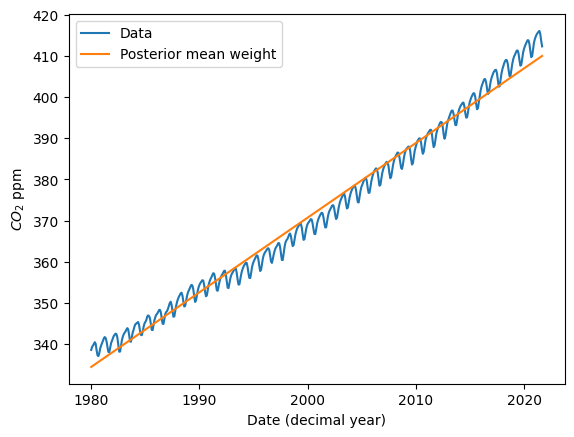

In [72]:
print(post_cov)
print(post_mean)

plt.plot(time, labels, label="Data")
plt.plot(time, time * post_mean[0] + post_mean[1], label="Posterior mean weight")

plt.xlabel("Date (decimal year)")
plt.ylabel("$CO_2$ ppm")
plt.legend()

In [73]:
def kernel_function(s, t):

    # vectorised Kernel function
    s = s.reshape(-1, 1)
    t = t.reshape(1, -1)

    # parameters
    theta = 3
    tau = 1
    sigma = 2
    phi = 1
    eta = 6
    zeta = 0.1

    A = np.exp(-2 / (sigma**2) * (np.sin(np.pi*(s-t)/tau))**2)
    B = phi**2 * np.exp(-((s-t)**2)/(2 * eta**2))
    C = zeta**2 * (s == t)

    cov_kernel = theta**2 * (A+B) + C

    return cov_kernel


Text(0, 0.5, '$CO_2$ ppm')

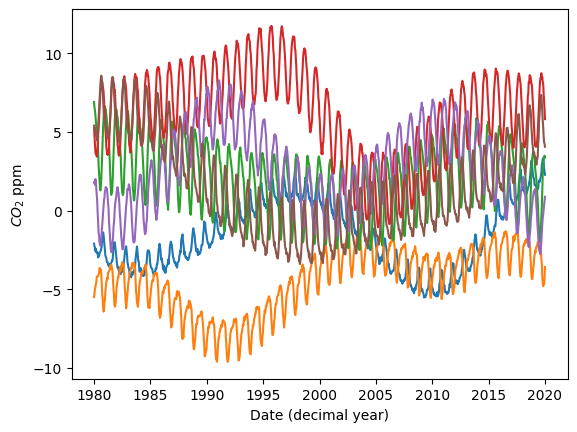

In [74]:
x = np.linspace(1980, 2020, 1000)

cov_kernel = kernel_function(x, x)

mean = np.zeros((cov_kernel.shape[0],))
plt.figure()

samples = np.random.multivariate_normal(mean, cov_kernel, 6).T

plt.plot(x, samples)
plt.xlabel("Date (decimal year)")
plt.ylabel("$CO_2$ ppm")


Text(0, 0.5, '$CO_2$ ppm')

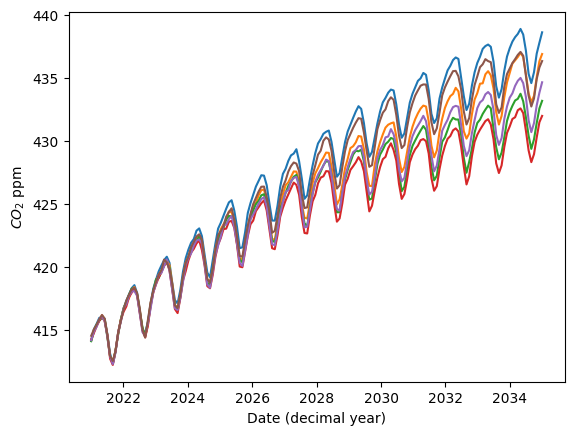

In [75]:
x = time
y = labels

features = np.concatenate((x[:, None], np.ones((x.shape))[:, None]), axis=1)
prior_cov = np.array([[100, 0], [0, 1000]])
post_cov = np.linalg.pinv(features.T @ features + np.linalg.pinv(prior_cov))
post_mean = post_cov @ features.T @ y

residuals = y - (x * post_mean[0] + post_mean[1])

# we want to model the c02 concentration to 2035
begin = 2021
end = 2035
domain = np.linspace(begin, end, 12*(end-begin))

# we calculated our posterior distribution conditioned on data
K = kernel_function(domain, domain)
Kxx = kernel_function(x, x)
Kx = kernel_function(domain, x)
Kxx_inv = np.linalg.pinv(Kxx)

# mean and cov of conditioned GP
mean = Kx @ Kxx_inv @ residuals
Cov = K - Kx @ Kxx_inv @ Kx.T

# Get samples from the posterior
samples = np.random.multivariate_normal(mean, Cov, 6).T

features_new = np.concatenate((domain[:, None], np.ones((domain.shape))[:, None]), axis=1)
f = samples + (features_new @ post_mean)[:, None]

# we plot the data with the extrapolation
plt.figure()
z = np.linspace(begin, end, 1000)
plt.plot(domain, f)
plt.xlabel("Date (decimal year)")
plt.ylabel("$CO_2$ ppm")


Text(0, 0.5, '$CO_2$ ppm')

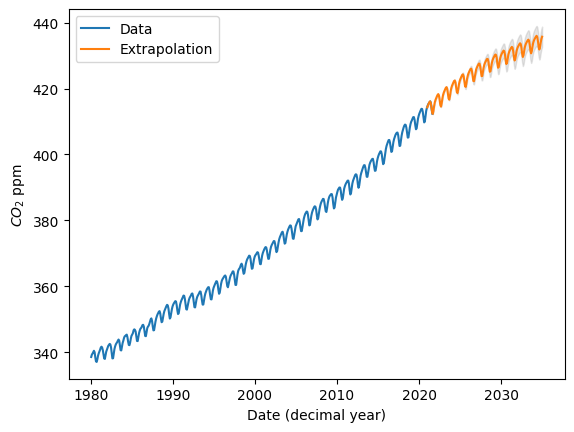

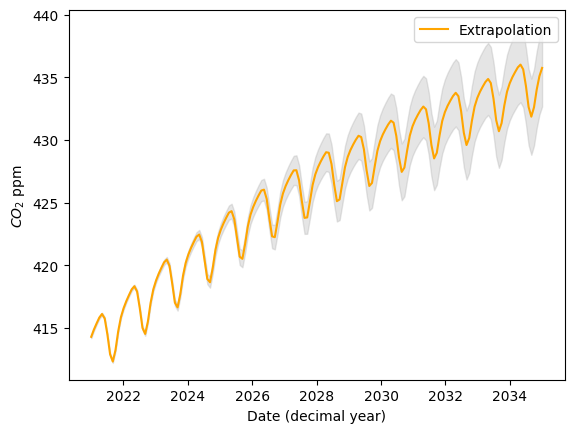

In [76]:
f_m = mean + features_new @ post_mean

# for the error bars
std = np.diag(Cov).flatten()**0.5

# we plot the extrapolation only
plt.figure()
plt.plot(x, y, label="Data")
plt.plot(domain, f_m, label="Extrapolation")
plt.fill_between(domain, f_m+std, f_m-std, alpha=0.3, color='darkgrey')
z = np.linspace(min(x), end, 1000)
plt.legend()
plt.xlabel("Date (decimal year)")
plt.ylabel("$CO_2$ ppm")

# we plot the data with the extrapolation
plt.figure()
z = np.linspace(begin, end, 1000)
plt.plot(domain, f_m, color='orange', label="Extrapolation")
plt.fill_between(domain, f_m+std, f_m-std, alpha=0.3, color='darkgrey')
plt.legend()
plt.xlabel("Date (decimal year)")
plt.ylabel("$CO_2$ ppm")